# Ulabox Online Retail Order Segmentation

** Table of Contents **

1. Introduction
2. Data Cleaning
3. Exploratory Data Analysis
4. Data Preparation
5. Principal Components Analysis
6. Cluster Analysis
7. Discussion



## 1. Introduction

This is an exploratory project using data from Ulabox, Spain's leading online grocery retailier. The dataset has been made public on Kaggle with this description:

> ** Context: **
>Ulabox is the most successful pure-player online grocery in Spain. It picks up more than €1 million in monthly revenue and asserts a customer satisfaction above 95%. It currently serves Madrid and Barcelona with fresh food and the rest of Spain's peninsula with non perishable items.

> ** Content **
The ulabox_orders_with_categories_partials_2017 dataset includes a subset of anonymized 30k orders from the beginning of 2017. All kind of customers (around 10k) are represented in this dataset: from urban and rural areas, from first-timers to loyal customers.

Data Source:
The Ulabox Online Supermarket Dataset 2017, accessed from https://www.github.com/ulabox/datasets




In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import boxcox
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN

In [2]:
# Read in raw data and have a peak
ula_raw = pd.read_csv("./data/ulabox_orders_with_categories_partials_2017.csv")
ula_raw.head()

,customer,order,total_items,discount%,weekday,hour,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%
0,0,0,45,23.03,4,13,9.46,87.06,3.48,0.00,0.00,0.00,0.0,0.0
1,0,1,38,1.22,5,13,15.87,75.80,6.22,2.12,0.00,0.00,0.0,0.0
2,0,2,51,18.08,4,13,16.88,56.75,3.37,16.48,6.53,0.00,0.0,0.0
3,1,3,57,16.51,1,12,28.81,35.99,11.78,4.62,2.87,15.92,0.0,0.0
4,1,4,53,18.31,2,11,24.13,60.38,7.78,7.72,0.00,0.00,0.0,0.0


Currently, each row of the dataset represents an order. Some customers have placed multiple orders, as seen above. Let's see what that distribution looks like.

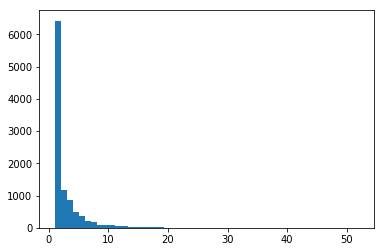

There are 10239 unique customers in the dataset of 30000 orders


1    4479
2    1944
3    1180
4     862
5     492
Name: order, dtype: int64

In [3]:
ula_pivot = pd.pivot_table(ula_raw, values='order', index='customer', aggfunc='count')

plt.hist(ula_pivot['order'], bins=50)
#plt.xlim(0, 105)
plt.show()
msg = "There are %d unique customers in the dataset of %d orders" % (len(ula_pivot), len(ula_raw))
print(msg)
ula_pivot.order.value_counts().head()

The number of orders per customer has an exponential distribution, with about 44% of customers having just one order in the dataset. Depending on how this dataset was extracted, this may or may not be all of each customer's order records. The dataset creators did say that these orders are all from early 2017 and that they represent many kinds of customers. For the sake of this analysis, I will assume that we do have all orders for each customer in the dataset.

Customer segmentation is typically performed with customer-level data. But since we have rich data at the order level, I will first look for patterns there.

## 2. Data Cleaning

In [4]:
# Add product category percentages as a check
ula_raw['Total%'] = ula_raw['Food%'] + ula_raw['Fresh%'] + ula_raw['Drinks%'] + ula_raw['Home%'] + ula_raw['Beauty%'] + ula_raw['Health%'] + ula_raw['Baby%'] + ula_raw['Pets%']
ula_raw.describe()

,customer,order,total_items,discount%,weekday,hour,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%,Total%
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,5012.483367,14999.500000,31.739933,8.455495,3.642367,15.034667,23.560406,20.227279,23.349235,13.539575,5.892949,1.132959,11.096145,1.043087,99.841636
std,2888.646245,8660.398374,20.576579,14.199350,2.122031,5.717052,21.719824,23.661767,22.523335,17.850282,13.996518,5.307620,24.740364,6.195390,1.886816
min,0.000000,0.000000,1.000000,-65.150000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.220000
25%,2541.750000,7499.750000,18.000000,1.177500,2.000000,11.000000,7.220000,0.000000,6.710000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000
50%,5043.000000,14999.500000,29.000000,4.160000,3.000000,15.000000,19.650000,10.930000,17.890000,7.210000,0.000000,0.000000,0.000000,0.000000,100.000000
75%,7483.000000,22499.250000,41.000000,9.990000,5.000000,20.000000,33.260000,35.790000,33.162500,20.002500,6.512500,0.000000,4.172500,0.000000,100.000000
max,10238.000000,29999.000000,298.000000,100.000000,7.000000,23.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,107.220000


The summary of the numeric data raises two issues:
1. We can see that there are some samples in the dataset that do not have total=100%.
2. There are negative discounts and discounts of 100%

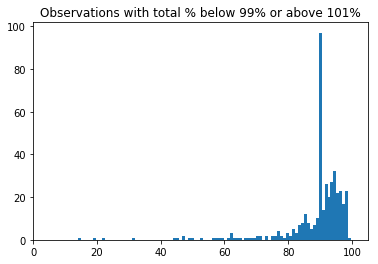

There are 416 potential outliers in the dataset of 30000 samples


In [5]:
# Examine outliers
ula_check = ula_raw[(ula_raw['Total%']<99.0) | (ula_raw['Total%']>101)]
plt.hist(ula_check['Total%'], bins=100)
plt.xlim(0, 105)
plt.title("Observations with total % below 99% or above 101%")
plt.show()
msg = "There are %d potential outliers in the dataset of %d samples" % (len(ula_check), len(ula_raw))
print(msg)

Since there are only 416 potential outliers in Total%, I will delete them from the dataset. Without knowing how the dataset was created I can't really guess how these values occurred. The dataset creator did comment that none of the orders involved cancellations or returns.

In [6]:
#Remove records that may have errors in the product category percentages
ula = ula_raw[(ula_raw['Total%']>=99.0) & (ula_raw['Total%']<=101)]

The dataset creator provided this information about the discount data:
>Ulabox applies recharges like: a sugar tax for processed food and drinks, or a difficult-to-transport recharge for very heavy items. As the normal discounts and recharges are processed at the same time, sometimes the value in this field is negative.

This is unfortunate since this type of recharge is not really related to discounting. A sugar tax, for example, is a required cost for the consumer, not an offset to a discount. It would be better if the discount and recharge amounts had been kept separate. However, these recharges are applied in the same manner to all orders, not just those that ended up with a negative discount. There is really nothing we can do about this as this it just the way the business has calculated this measure.

>And by the way, on the other side of the spectrum: a 100% discount is a "free order" discount that is usually dispatched to influencers.

Give-aways to influencers are a different kind of marketing expense than a discount on retail customer orders, so we can go ahead and delete these from the dataset.

In [7]:
freebies = len(ula_raw[(ula_raw['discount%']==100.0)])
#print("There are "  freebies " samples with 100% discount.")
msg = "There are %d samples with 100 percent discount." % freebies
print(msg)

recharge = len(ula_raw[(ula_raw['discount%']<0)])
#print("There are "  freebies " samples with 100% discount.")
msg = "There are %d samples with negative discount." % recharge
print(msg)

#Remove records that have 100% discount
ula = ula_raw[(ula_raw['discount%']!=100.0)]

There are 396 samples with 100 percent discount.
There are 126 samples with negative discount.


Next we will take a closer look at the numeric variables.

## 3. Exploratory Data Analysis

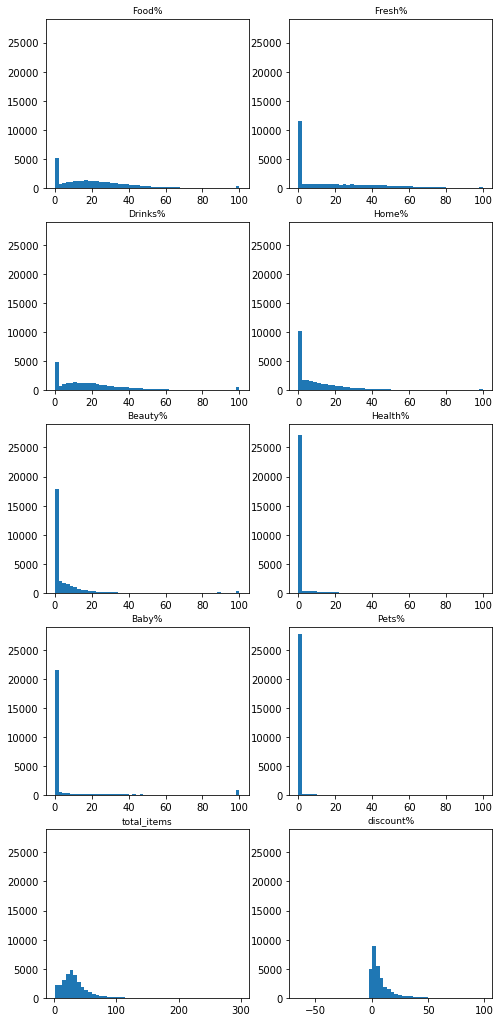

In [8]:
# Review distributions of potential predictor variables
prod = ula[['Food%', 'Fresh%', 'Drinks%', 'Home%', 'Beauty%', 'Health%', 'Baby%', 'Pets%',
            'total_items', 'discount%']]

fig = plt.figure()

num=1
for column in prod:
    # Find the right spot on the plot
    ax = plt.subplot(5, 2, num)
    fig.set_size_inches(8, 18, forward=True)
    
    plot_var = ula[column]
    plt.hist(plot_var, bins=50)
    #sns.kdeplot(plot_var, shade=True, linewidth=1, legend=False, color='g') #
    title = column #+ "(log): " + v_normal
    plt.title(title, fontsize=9)
    ax.set_ylim(0, 29000)
   
    num+=1
      
plt.show()      

These histograms have the same y axis to show that for several categories (Beauty, Health, Baby, and Pets) most orders do not contain any products from those categories. Zero percent is the mode for all of the product categories. This data is difficult to transform to Gaussian approximation. Therefore I will instead dichotomize these measures into dummy variable that indicate whether or not the category was prsent in the order.

The distribution of discount% is skewed, and the rest of the numeric variables appear to have exponential distributions. I will use a Boxcox transformation on these variables to better approximate a normal distribution. For the discount% I will first add a constant to all observations to eliminate negative numbers. These features will then be standardized in the next step.

In [9]:
# Create dataset for transformed features
ula_tran = ula.copy()
min_disc = np.min(ula_tran['discount%'])
ula_tran['discount%'] = ula_tran['discount%'] - min_disc

In [10]:
# Create dummy product category indicators
prod = ['Food%', 'Fresh%', 'Drinks%', 'Home%', 'Beauty%', 'Health%', 'Baby%', 'Pets%']
names = ['Food', 'Fresh', 'Drinks', 'Home', 'Beauty', 'Health', 'Baby', 'Pets']
for index in range(len(prod)):
    ula_tran[names[index]] = (ula_tran[prod[index]]>0).astype(int)

In [11]:
# Create aggregate product measure
cat_per = (ula_tran[['Food', 'Fresh', 'Drinks', 'Home', 'Beauty', 'Health', 'Baby', 'Pets']].aggregate('mean'))*100
cat_avg = ula_tran[['Food%', 'Fresh%', 'Drinks%', 'Home%', 'Beauty%', 'Health%', 'Baby%', 'Pets%']].aggregate('mean')

In [12]:
# What % of orders contain at east one product category?
cat_per.sort_values(ascending=False)

Drinks    84.117011
Food      83.309688
Home      68.608972
Fresh     61.978111
Beauty    41.862586
Baby      28.053641
Health     9.650723
Pets       6.711931
dtype: float64

In [13]:
# What is mean % share of monetary value of orders?
cat_avg.sort_values(ascending=False)

Drinks%    23.643706
Food%      22.593341
Fresh%     20.469054
Home%      13.719389
Baby%      11.242356
Beauty%     5.967042
Health%     1.147911
Pets%       1.056986
dtype: float64

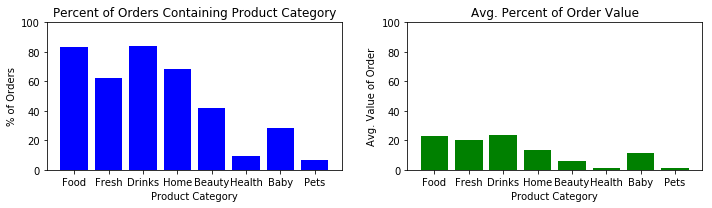

In [14]:
# Plot distribution of product categories across orders
x=['Food', 'Fresh', 'Drinks', 'Home', 'Beauty', 'Health', 'Baby', 'Pets']

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].bar(x, cat_per, color='b')
axs[0].set_xlabel("Product Category")
axs[0].set_ylabel("% of Orders")
axs[0].set_ylim([0, 100])
axs[0].set_title("Percent of Orders Containing Product Category")

axs[1].bar(x, cat_avg, color='g')
axs[1].set_xlabel("Product Category")
axs[1].set_ylabel("Avg. Value of Order")
axs[1].set_ylim([0, 100])
axs[1].set_title("Avg. Percent of Order Value")

fig.tight_layout()
plt.show()

These charts show how the product categories are distributed across orders. More than half of all orders contain a product from the Drinks category (84%), and the same is true for the Food, Home, and Fresh categories. Less than 10% of all orders contain products from the Pets or Health categories.

The share of order value largely follows these patterns. On average, Drinks, Food, and Fresh products make up over 20% of each order. On average, Pet and Health products account for just 1% of order value.

In [15]:
ula_tran['cat_count'] = ula_tran['Food'] + ula_tran['Fresh'] + ula_tran['Drinks'] + ula_tran['Home'] + ula_tran['Beauty'] + ula_tran['Health'] + ula_tran['Baby'] + ula_tran['Pets']

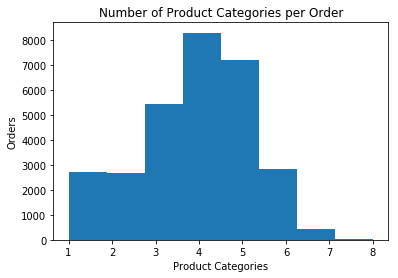

In [16]:
plt.hist(ula_tran.cat_count, bins=8)
plt.title("Number of Product Categories per Order")
plt.xlabel("Product Categories")
plt.ylabel("Orders")
plt.show()

The number of product categories represented in individual orders is distributed fairly normally, although single-category orders are overrepresented.

In [17]:
#Save identifier and numeric columns for later
ula_id = ula_tran[['order', 'customer', 'hour', 'total_items', 'discount%', 'cat_count']]

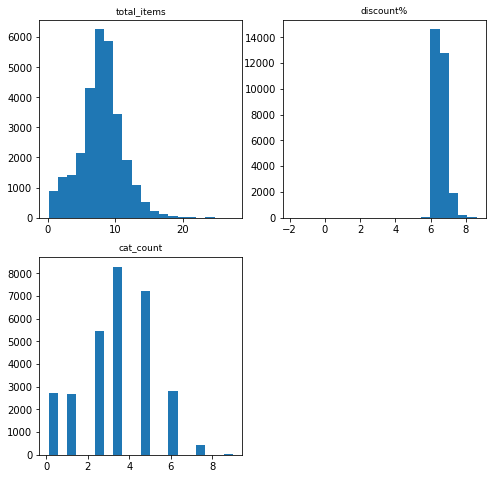

In [18]:
# Transform all the numeric columns in input data, due to skewness
from scipy.stats import boxcox

vars = ['total_items', 'discount%', 'cat_count']

fig = plt.figure()

num=1
for col in vars:
    # use boxcox square root
    ula_tran[col] = boxcox(ula_tran[col] + 0.1)[0]
        # Find the right spot on the plot
    plt.subplot(2, 2, num)
    fig.set_size_inches(8, 8, forward=True)
    
    plot_var = ula_tran[col]
    plt.hist(plot_var, bins=20)
    #sns.kdeplot(plot_var, shade=True, linewidth=1, legend=False, color='g') #
    title = col 
    plt.title(title, fontsize=9)
    
    num+=1
      
plt.show()      
 

Above are the transformed numeric features. Next we will explore the time and day features of the dataset.

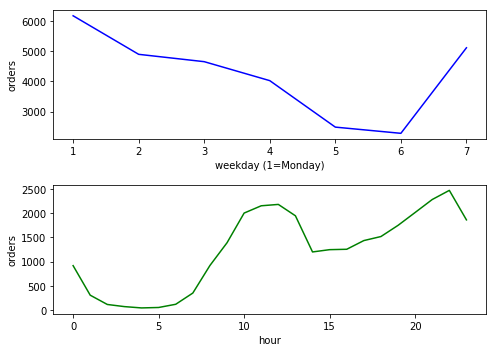

In [19]:
#Plot orders over time

days = pd.pivot_table(ula, values='order', index='weekday', aggfunc='count')
hours = pd.pivot_table(ula, values='order', index='hour', aggfunc='count')
fig, axs = plt.subplots(2, 1, figsize=(7, 5))
axs[0].plot(days['order'], 'b')
axs[0].set_xlabel("weekday (1=Monday)")
axs[0].set_ylabel("orders")
axs[1].plot(hours['order'], 'g')
axs[1].set_xlabel("hour")
axs[1].set_ylabel("orders")
fig.tight_layout()
#fig.suptitle('Number of Orders by Day and Hour')
plt.show()

In this dataset 1=Monday and 7=Sunday, so we can see that the most orders occur on Monday and Sunday while orders are much lower on Friday and Saturday. The most popular time for ordering is between 10-11pm, followed by 10am-noon.

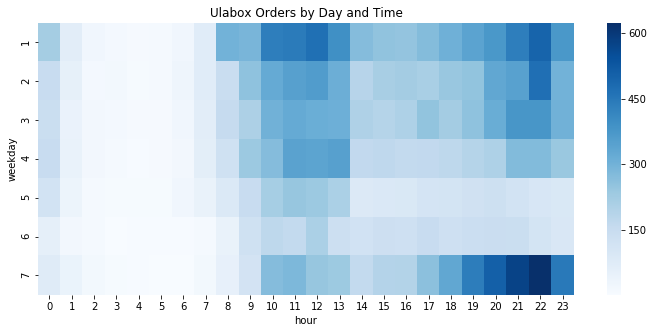

In [20]:
heatmap = pd.pivot_table(ula, values='order', index='weekday', columns='hour', aggfunc='count')

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
#plt.gca().invert_yaxis()
#plt.ylim(1999, 2016) 
plt.title('Ulabox Orders by Day and Time') 
sns.heatmap(heatmap, cmap = 'Blues')
#ax.set_xlabel('Counties (Sorted by Mean Drug Mortality)')
ax = plt.gca()
plt.show()

This heatmap shows that most of the late evening orders are placed on Sunday. Overall, Sunday evening and Monday midday are the most common times for orders to be placed.

Although time is generally a continuous variable, in this case we do not have the date of the order and so we will not be able to treat time as continuous. If we tried to do so, distance-based clustering methods would interpret hour 23 as very far from hour 0, which it is not. Since we have over 29,000 samples and not too many features, I will treat both weekday and hour as categorical variables and one-hot encode them prior to clustering. The hour of the day will first be grouped into categories as follows:

| Hour | Code | Time of Day   |
|------|------|---------------|
| 1-7  | 1    | Overnight     |
| 8-10 | 2    | Early Morning |
| 11-13 | 3    | Midday        |
| 14-16  | 4    | Afternoon     |
| 17-19  | 5    | Evening       |
| 20-0 | 6    | Late Evening  |

In [21]:
# Recode hours to categories
def recode(x): 
    """Recode hours to categories"""
    if (x >= 1) & (x <= 7): 
        return 1
    elif (x >= 8) & (x <= 10): 
        return  2
    elif (x >= 11) & (x <= 13): 
        return  3
    elif (x >= 14) & (x <= 16): 
        return  4
    elif (x >= 17) & (x <= 19): 
        return  5
    elif (x >= 20) | (x == 0):  
        return  6 

ula_tran['time_cat'] = ula_tran['hour'].apply(recode)   

## 4. Data Preparation

The data is prepared for cluster analysis by dropping unneeded features, scaling numeric variables and one-hot encoding the day and time features.

In [22]:
#Create dataset for cluster analysis
ula_cluster = ula_tran.drop(columns=['order', 'customer', 'hour', 'Food%', 'Fresh%', 'Drinks%', 'Home%', 'Beauty%', 'Health%', 'Baby%', 'Pets%'])
#ula_cluster.info()

In [23]:
# list numeric features for pipeline
num_vars = ['discount%', 'total_items', 'cat_count']
# list categorical features for pipeline
cat_vars = ['time_cat', 'weekday']

# Create numeric and categorical transformations
num_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[('onehot', OneHotEncoder(categories='auto'))])

preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_vars),
        ('cat', cat_pipeline, cat_vars)],
        remainder='passthrough')

In [24]:
# Create transformed dataset
X = preprocessor.fit_transform(ula_cluster)

## 5. PCA Feature Reduction

The next step will be to see if we can simplify the data through principal components analysis.

In [25]:
pca = sklearn.decomposition.PCA(random_state=58)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=58,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
pca_expl_var = pd.DataFrame(pca.explained_variance_ratio_).reset_index()
pca_expl_var.columns = ["PC", "expl_var"]
#pca_expl_var.head()

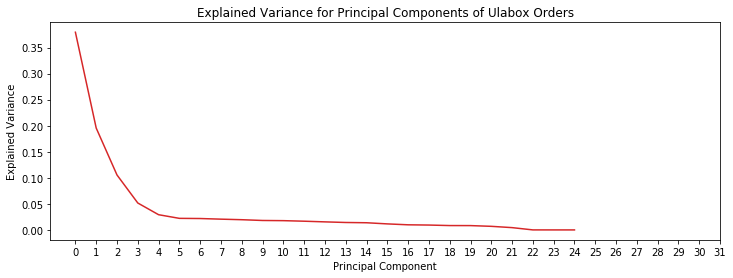

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4, forward=True)

plt.title('Explained Variance for Principal Components of Ulabox Orders') 
plt.plot(pca_expl_var.PC, pca_expl_var.expl_var, color = 'tab:red')

ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
ax.set_xticks(np.arange(0, 32, step=1))
#plt.xticks(np.arange(0, n_clusters, step=1))
#plt.ylim(0, 0.2) 

plt.show()

The above plot shows that by 4 principal components we have captured over 95% of the variance in the dataset. I will reduce the original data to these 4 components.

In [28]:
seed=58
pca = sklearn.decomposition.PCA(n_components=4, random_state=seed)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=58,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
X_pca = pca.transform(X)

## 6. Clustering Order Data

Next I use K-means, which is a good general purpose clustering technique. Since I don't know how many clusters we might find, I will test the range 3-20 clusters and compare both the sums of squares and the silhouette score for the models.

In [30]:
# evaluate K-means models of PCA-reduced data
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

sse_score = []
sil_score = []
for k in k_values:
    model = KMeans(n_clusters=k, random_state=58)
    km = model.fit(X_pca)
    sse_score.append(km.inertia_)
    cluster_labels = km.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    sil_score.append(silhouette_avg)

    msg = "Clusters:%s SSE:%f.2 Sil: %f.3" % (k, km.inertia_, silhouette_avg)
    print(msg)
    print(pd.Series(cluster_labels).value_counts())

Clusters:2 SSE:142620.130542.2 Sil: 0.860959.3
0    29378
1      226
dtype: int64
Clusters:3 SSE:106785.087797.2 Sil: 0.347533.3
0    19026
2    10487
1       91
dtype: int64
Clusters:4 SSE:78123.358783.2 Sil: 0.352612.3
0    18701
2    10597
1      276
3       30
dtype: int64
Clusters:5 SSE:63644.991561.2 Sil: 0.361047.3
3    16769
0     8634
2     3896
4      275
1       30
dtype: int64
Clusters:6 SSE:54211.785571.2 Sil: 0.301460.3
3    11176
0    10357
1     4240
5     3526
4      275
2       30
dtype: int64
Clusters:7 SSE:48234.517920.2 Sil: 0.302440.3
0    11173
5    10346
2     4249
3     3516
6      274
1       35
4       11
dtype: int64
Clusters:8 SSE:43263.353987.2 Sil: 0.295158.3
2    10420
1     7075
7     4457
5     3984
0     3349
6      273
3       35
4       11
dtype: int64
Clusters:9 SSE:39295.780330.2 Sil: 0.303915.3
0    9928
2    6402
8    4092
4    3834
5    3480
7    1550
3     272
1      35
6      11
dtype: int64
Clusters:10 SSE:36460.698749.2 Sil: 0.280985.3
0   

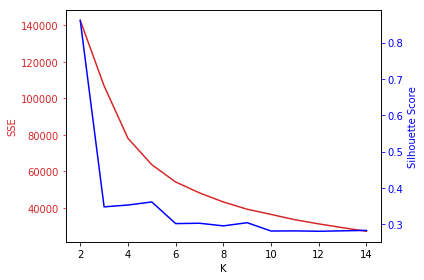

In [31]:
# plot the K-means SSE and Silhouette scores

fig, ax1 = plt.subplots()
ax1.plot(k_values, sse_score, color = 'tab:red')
ax1.set_xlabel('K')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SSE', color='tab:red')
ax1.tick_params('y', colors='tab:red')
ax1.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

ax2 = ax1.twinx()
ax2.plot(k_values, sil_score, color = 'blue')
ax2.set_ylabel('Silhouette Score', color='blue')
ax2.tick_params('y', colors='blue')

fig.tight_layout()
plt.show()

There does not seem to be a clear 'elbow' in the SSE curve, though there are slight breaks in the rate of SSE improvement at 4, 5, and 6 clusters. The silhouette scores for these models are highest for 2 and 5 clusters, although the 2-cluster model is highly imbalanced and therefore not practical. We can use silhouette plots to further explore the most promising models. 

The average silhouette_score is:  0.34753319539204913
Clusters:3 SSE:106785.087797.2 Sil: 0.347533.3
0    19026
2    10487
1       91
dtype: int64
The average silhouette_score is:  0.35261226959718256
Clusters:4 SSE:78123.358783.2 Sil: 0.352612.3
0    18701
2    10597
1      276
3       30
dtype: int64
The average silhouette_score is:  0.3610467160272527
Clusters:5 SSE:63644.991561.2 Sil: 0.361047.3
3    16769
0     8634
2     3896
4      275
1       30
dtype: int64
The average silhouette_score is:  0.30146038925905255
Clusters:6 SSE:54211.785571.2 Sil: 0.301460.3
3    11176
0    10357
1     4240
5     3526
4      275
2       30
dtype: int64


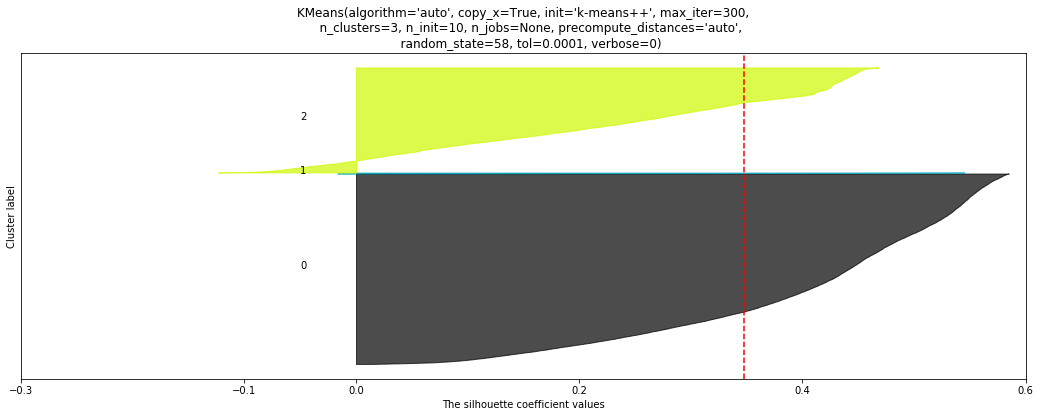

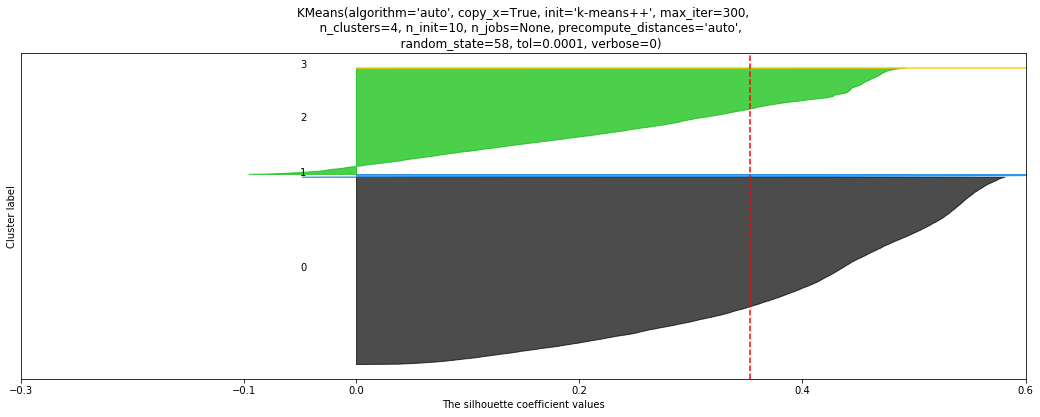

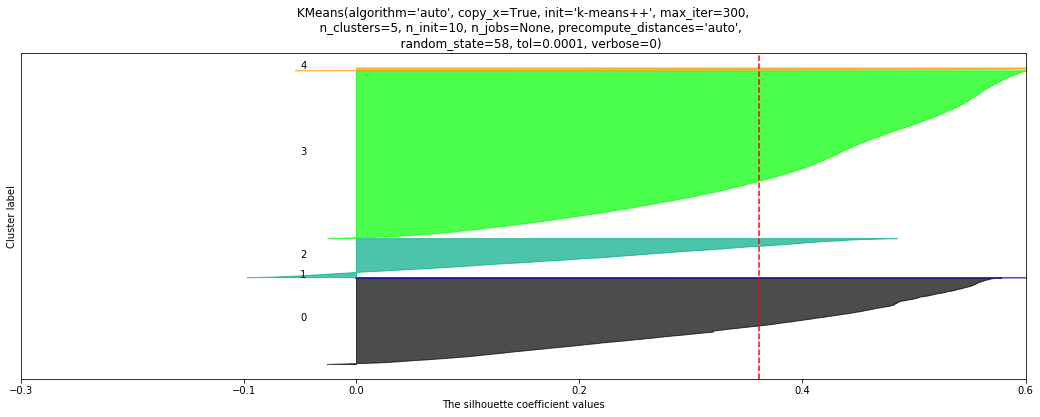

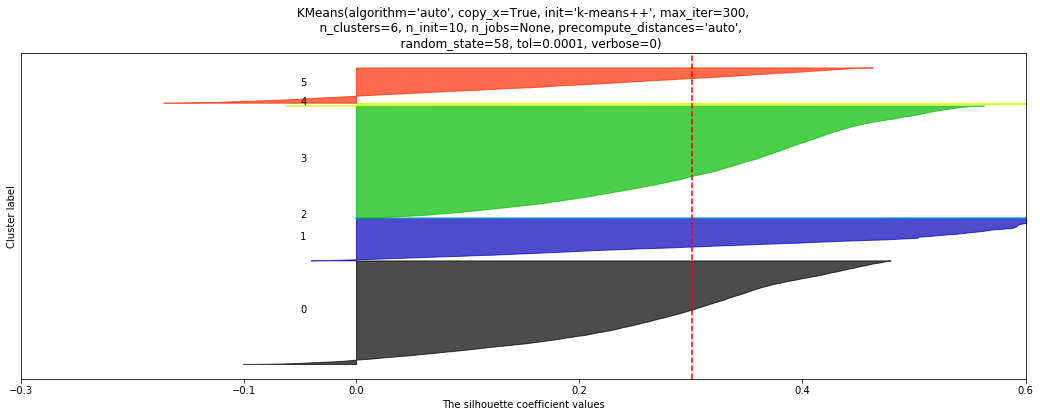

In [32]:
# Make silhouette plots
seed=58

model_list = []
model_list.append((KMeans(n_clusters=3, random_state=seed)))
model_list.append((KMeans(n_clusters=4, random_state=seed)))
model_list.append((KMeans(n_clusters=5, random_state=seed)))
model_list.append((KMeans(n_clusters=6, random_state=seed)))

score=[]

for model in model_list:
    # Create a subplot 
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 6)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, .5]
    ax1.set_xlim([-0.3, .5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, X_pca_sample_pca.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value 
    clusterer =  model.fit(X_pca) 
    cluster_labels = clusterer.labels_
    cluster_dist = pd.DataFrame(cluster_labels, columns=['Cluster'])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("The average silhouette_score is: ", silhouette_avg)
    msg = "Clusters:%s SSE:%f.2 Sil: %f.3" % ((model.get_params()["n_clusters"]),
                                              clusterer.inertia_, silhouette_avg)
    print(msg)
    print(pd.Series(cluster_labels).value_counts())
    score.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(model.get_params()["n_clusters"]):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) /model.get_params()["n_clusters"])
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(model)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.3, -0.1, 0, 0.2, 0.4, 0.6, ])

    #plt.suptitle(("Comparison of Clustering Models"), fontsize=14, fontweight='bold')

plt.show()

The 5-cluster model, which has the highest average Silhouette score, has several advantages. It produces three good-size clusters, with two small clusters that may or may not  be useful. And the 5-cluster model contains few samples with negative silhouette scores, indicating consistency within the clusters.

## Plot clusters on PC1 and PC2

Next we will use the first two princiapl components to illustrate our cluster model.

In [33]:
# Add PCA loadings to dataset
ula_tran['x'] = pca.fit_transform(X)[:,0]
ula_tran['y'] = pca.fit_transform(X)[:,1]

In [34]:
# Recreate best K-means model
n_clusters=5
seed=58
model = KMeans(n_clusters=n_clusters, random_state=seed)
km5 = model.fit(X_pca)
clusters = km5.predict(X_pca)
ula_tran['cluster5'] = km5.predict(X_pca)

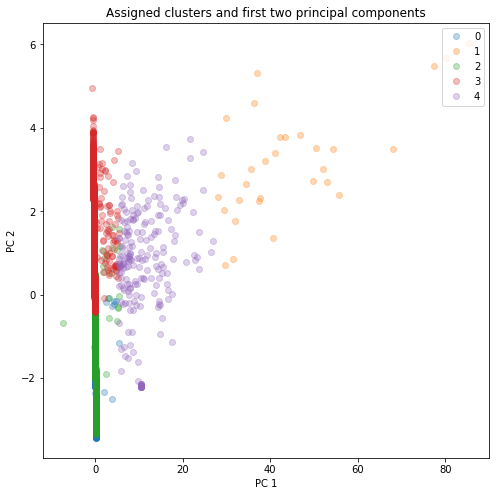

In [35]:
cluster_list = np.arange(km5.get_params()['n_clusters'])

# Plot clusters on PCA axes
fig, ax = plt.subplots()
fig.set_size_inches(8, 8, forward=True)
plt.title('Assigned clusters and first two principal components') 

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#for cluster, group in groups:
for cluster in cluster_list:
    plot_data = ula_tran[ula_tran['cluster5']==cluster]
    ax.plot(plot_data.x, plot_data.y, marker='.', linestyle='', alpha=0.3, ms=12, label=cluster)
ax.legend(loc=1)

plt.show()

The above plot shows that the first two principal components do a good job of differentialting the clusters. Clusters 2 and 3 (green and red) are differentiated on PC2 but are identical on PC1. PC1 serves to differentiate Clusters 1 and 4 from the rest. But where is Cluster 0, which accounts for 29% (n=8625) of the order samples?

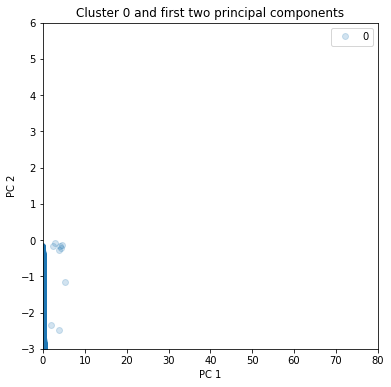

In [36]:
# Plot clusters on PCA axes
fig, ax = plt.subplots()
fig.set_size_inches(6, 6, forward=True)
plt.title('Cluster 0 and first two principal components') 

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_xlim(0, 80)
ax.set_ylim(-3, 6)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

plot_data = ula_tran[ula_tran['cluster5']==0]
ax.plot(plot_data.x, plot_data.y, marker='.', linestyle='', alpha=0.2, ms=12, label="0")
#color=['skyblue', 'gold', 'slateblue', 'yellowgreen'])
ax.legend(loc=1)

plt.show()

Here is a plot of Cluster 0 all by itself on the same axes as above. We can see that it must be similar to Cluster 2 since it was hiding underneath. We can assume that Cluster 0 is differentiated from Cluster 2 by either PC3 or PC4, which are not shown in 2D.

## Compare clusters according to original, untransformed features

In [37]:
ula_labelled = ula_tran.drop(columns=['total_items', 'discount%', 'cat_count'])
ula_labelled['total_items'] = ula_id['total_items']
ula_labelled['discount%'] = ula_id['discount%'] + min_disc
ula_labelled['cat_count'] = ula_id['cat_count']
ula_labelled['hour'] = ula_id['hour']
ula_labelled['order'] = ula_id['order']
ula_labelled['customer'] = ula_id['customer']

In [38]:
ula_labelled.cluster5.value_counts()

3    16769
0     8634
2     3896
4      275
1       30
Name: cluster5, dtype: int64

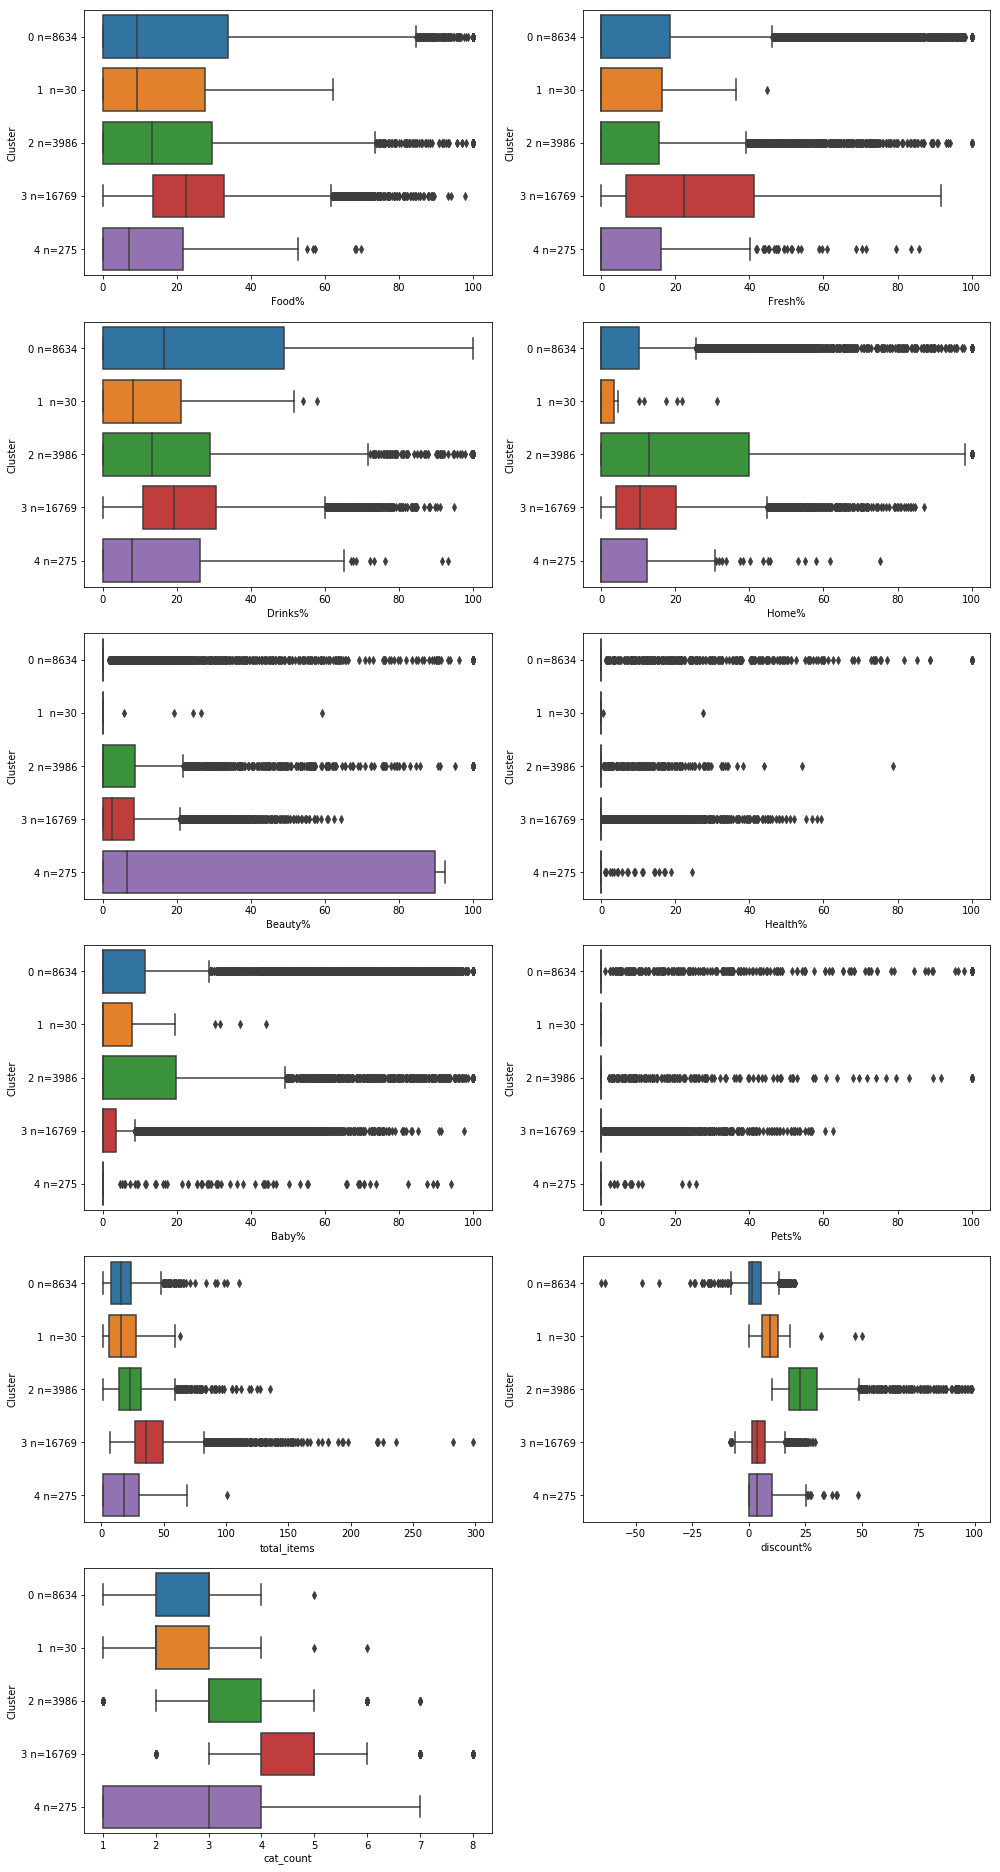

In [42]:
# Review distributions of potential predictor variables
var_list = ['Food%', 'Fresh%', 'Drinks%', 'Home%', 'Beauty%', 'Health%', 'Baby%', 'Pets%',
            'total_items', 'discount%', 'cat_count']

fig = plt.figure()

num=1
for var in var_list:
    # Find the right spot on the plot
    ax = plt.subplot(7, 2, num)
    fig.set_size_inches(14, 30, forward=True)
    
    plot_var = ula_labelled[var]
    sns.boxplot(x=plot_var, y='cluster5', data=ula_labelled, linewidth=1.5, orient='h')
    #plt.title('Mean Drug Mortality by Ubanization Code')
    ax.set_xlabel(var)
    ax.set_ylabel("Cluster")
    ax.set_yticklabels(('0 n=8634', '1  n=30', '2 n=3986', '3 n=16769', '4 n=275'))
   
    num+=1
fig.tight_layout()      
plt.show()      

The boxplots above show the distibutions of original, untransformed features as well as calculated numeric fields within each cluster.

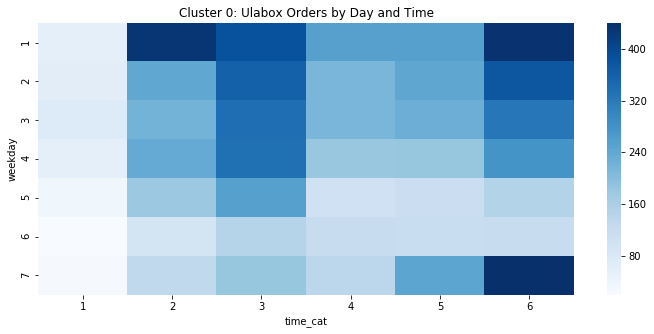

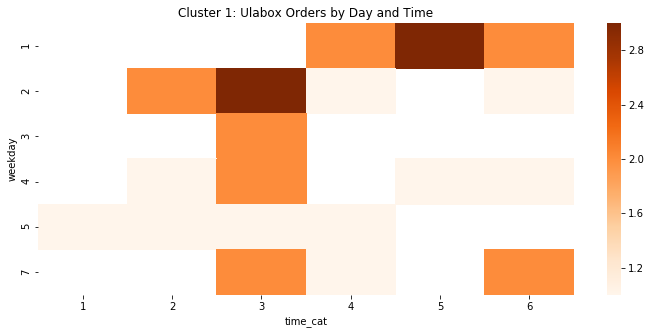

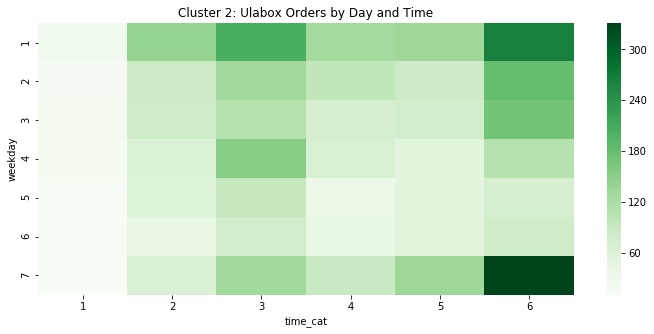

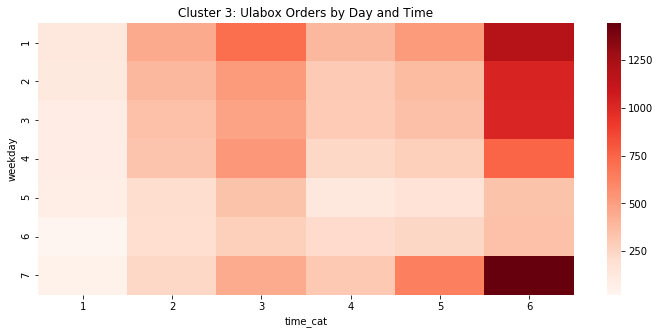

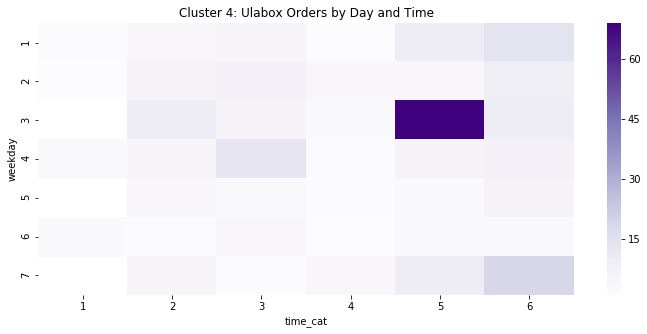

In [41]:
colors = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']

for cluster in cluster_list:
    heatmap = pd.pivot_table(ula_tran[ula_tran['cluster5']==cluster], values='order', index='weekday', columns='time_cat', aggfunc='count')

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5)
    title = ("Cluster " + str(cluster) + ": Ulabox Orders by Day and Time")
    plt.title(title) 
    sns.heatmap(heatmap, cmap = colors[cluster])
    #ax.set_xlabel('Counties (Sorted by Mean Drug Mortality)')
    ax = plt.gca()
    plt.show()

The heatmaps above show the distribution of the 5 order clusters over weekday and time.

## 7. Discussion

We can use the information above to describe and label the 5 clusters identified by K-means. I will review the clusters in the order of their frequency.

** Cluster 3: n=16734 **
- strong tendency to order in late evening, especially Sunday or Monday nights.
- most likely to include food or fresh products
- consistently includes drinks, but never 100%
- 2nd most likely to inclue home or beauty products
- highest total items and highest mean category count
- modest discounts

Summary: Cluster 3 orders (shown in red above) are the largest category of orders (57%), and they are also the largest in terms of total items and number of product categories included. These orders are most often placed on Sunday or Monday evening. They orders are the most likely to contain products from the 'Fresh' category. These orders have the hallmarks of planned weekly grocery shopping for a family or other household. 

Since 'Fresh' is only available in Barcelona and Madrid, the presence of 'Fresh' products may be more of an indicator of geography than of preference. Adding geography data to the model could help clear this up.

Let's call the orders ** Fresh Family Shopping **

** Cluster 0: n=8625 **
 - avg. on food & fresh
 - above avg. drinks (though not as much as Cluster3)
 - avg home, moderate baby
 - low beauty products
 - low total items
 - low cat count (2-3)
 - negative discounts (probably due to drinks recharge)
 - tend to be placed Sunday night, Monday night, or Monday morning
 
Cluster 0 (shown in blue above) is the second largest cluster of orders, accounting for 29% of orders. These orders tend to have a low total number of items and low category county. They are a bit less likley to contain food or fresh items,and can contain a large share of drinks. These orders tend to occur at the beginning of the week, but are less concentrated in time. These orders have the hallmarks of being part of regular weekly shopping, but they may be for smaller families or for families that also regularly buy groceries at a store.

Let's call the orders ** Small Family Shopping **


Cluster 2: n=3940
- Orders tend to happen late evening Sunday or Monday.
- highest discount % and most likely to contain baby products or home products
- small total items and cat count
- avg drinks, fresh, and food

Cluster 2 (shown in green above) is the third largest cluster of orders, accounting for 13% of orders. These orders tend to have a low total number of items and low category count. They most likley to contain baby or home products. These orders tend to occur at the beginning of the week. These orders have the hallmarks of being part of regular weekly shopping, but they may be for younger families with small children who are more sensitive to pricing and motivated by discounts.

Let's call these orders ** Small Children Family Shopping **


Cluster 1: n=275
 - Wednesday evening
 - most likely to include beauty products
 - but lower than others on all other product categories
 - orer avg. amount of items but can be from many categories (or not)
 
Cluster 1 (shown in purple above) is a small cluster, accounting for 1% of orders. These orders are the most likely to contain beauty products. They tend to be placed on Wednesday evenings, which seems unusual but could be a result of weekly advertisements, discounts, or messages sent to loyalty club members. On the other hand the discounts for these orders are just average. These orders tend to have an average number of items, but can have a large category count. 

A cluster this small may not be very meaningful, but let's call it ** Beauty Shopping **


Cluster 4: n=30
- smallest orders in terms of items
- typically few categories
- lowest beauty, health, pets, and home products
- low fresh
- avg. food
- orders tend to be placed Monday evening or Tuesday midday

This cluster (shown in orange above) is the smallest of all, and may not be meaningful. These are small orders that tend to contain food products. Let's call them ** Afterthoughts & Emergencies **

### Next Steps and Recommendations
Cluster analysis identified 5 types of orders in the dataset. The next step in the anlaysis will be to aggegate the data to the customer level and see if we can use the order types to segment the customers.

There are some issues with the data that Ulabox has provided that make the analysis more difficult.
One thing that would improve the analysis would be to separate the data on discounts and recharges to get a better sense of the impact of discounting on orders. It would also be helpful to add data on order location to the models. This would help clarify whether orders that do not contain 'Fresh' products are reflective of consumer preference or simple geographic availability of 'Fresh' products. 